In [1]:
import os
import xml.etree.ElementTree as ET

from torch.utils.data import Dataset
import timm
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
word_xml_path = "Dataset/words.xml"
root = ET.parse(word_xml_path).getroot()

img_paths = []
img_sizes = []
img_labels = []
bounding_boxes = []

for img in root:
    bbox_word = []
    label_word = []
    for words in img.findall("taggedRectangles"):
        for word in words:
            if not word[0].text.isalnum():
                continue
            if "é" in word[0].text.lower() or "ñ" in word[0].text.lower():
                continue
            bbox_word.append([
                float(word.attrib["x"]),
                float(word.attrib["y"]),
                float(word.attrib["width"]),
                float(word.attrib["height"])
            ])
            label_word.append(word[0].text.lower())
    
    img_paths.append(img[0].text)
    img_sizes.append((int(img[1].attrib["x"]), int(img[1].attrib["y"])))
    img_labels.append(label_word)
    bounding_boxes.append(bbox_word)
    
print(img_paths[0], img_sizes[0], img_labels[0], bounding_boxes[0])

print(len(img_paths), len(img_labels), len(img_sizes), len(bounding_boxes))

apanar_06.08.2002/IMG_1261.JPG (1600, 1200) ['self', 'adhesive', 'address', 'labels', '36', '89m', 'cls', '250', 'on', 'a', 'roll'] [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0], [184.0, 612.0, 622.0, 174.0], [863.0, 599.0, 446.0, 187.0], [72.0, 6.0, 95.0, 87.0], [247.0, 2.0, 197.0, 88.0], [792.0, 0.0, 115.0, 81.0], [200.0, 848.0, 228.0, 139.0], [473.0, 878.0, 165.0, 109.0], [684.0, 878.0, 71.0, 106.0], [806.0, 844.0, 218.0, 141.0]]
250 250 250 250


In [3]:
def split_bbox(img_paths, img_labels, bboxes, save_dir,):
    os.makedirs(save_dir, exist_ok=True)
    
    count = 0
    labels = []
    for img_path, img_label, bbox  in zip(img_paths, img_labels, bboxes):
        img_path = os.path.join("Dataset", img_path)
        img = Image.open(img_path)
        for label, bb in zip(img_label, bbox):
            crop_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))
            
            if np.mean(crop_img.size) < 35 or np.mean(crop_img) > 220:
                continue
            if crop_img.size[0] < 10 or crop_img.size[1] < 10: 
                continue
            if len(img_label) < 3:
                continue
            
            file_name = f"{count:06d}.jpg"
            crop_img.save(os.path.join(save_dir, file_name))
            new_img_path = os.path.join(save_dir, file_name)
            label = new_img_path + "\t" + label
            labels.append(label)
            count += 1
    print(f"Created {count} images")
    
    with open(os.path.join(save_dir, "labels.txt"), "w") as f:
        for label in labels:
            f.write(f"{label}\n")

In [4]:
save_dir = "CRNN_data"
split_bbox(img_paths, img_labels, bounding_boxes, save_dir)

Created 840 images


In [5]:
img_paths = []
labels = []

with open(os.path.join("CRNN_data", "labels.txt"), "r") as f:
    for label in f:
        labels.append(label.strip().split("\t")[1])
        img_paths.append(label.strip().split("\t")[0])

print(f"Total labels: {len(labels)}")
print(f"Total img: {len(img_paths)}")

Total labels: 840
Total img: 840


In [6]:
letters = [char.split(".")[0] for char in labels]
letters = "".join(letters)
letters = sorted(set(letters))
print(letters)

chars = "".join(letters)


chars += "-"
vocab_size = len(chars)
print(f"Vocab: {chars}")
print(f"Vocab size: {vocab_size}")

['0', '1', '2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab: 012345678abcdefghijklmnopqrstuvwxyz-
Vocab size: 36


In [7]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx : char for char, idx in char_to_idx.items()}
max_len = max([len(label) for label in labels])
print(idx_to_char)
print(char_to_idx)
max_len

{1: '-', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: 'a', 12: 'b', 13: 'c', 14: 'd', 15: 'e', 16: 'f', 17: 'g', 18: 'h', 19: 'i', 20: 'j', 21: 'k', 22: 'l', 23: 'm', 24: 'n', 25: 'o', 26: 'p', 27: 'q', 28: 'r', 29: 's', 30: 't', 31: 'u', 32: 'v', 33: 'w', 34: 'x', 35: 'y', 36: 'z'}
{'-': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'h': 18, 'i': 19, 'j': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'x': 34, 'y': 35, 'z': 36}


14

In [8]:
def encode(label, idx_char, max_len):
    encoded_labels = torch.tensor(
        [idx_char[char] for char in label],
        dtype=torch.long
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.long
    )
    padded_labels = F.pad(encoded_labels, (0, max_len - label_len), value=0)
    
    return padded_labels, lengths

test1, test2 = encode("self", char_to_idx, max_len)
test1, test2

(tensor([29, 15, 22, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor(4))

In [9]:
def decode(encoded_sequences, idx_to_char, blank_char= "-"):
    decoded_sequences = []
    
    for seq in encoded_sequences:
        decoded = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()] 
                if char != blank_char:
                    decoded.append(char)
                    
        decoded_sequences.append("".join(decoded))
    return decoded_sequences

decode([test1], idx_to_char)

['self']

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((100, 400)),
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4
    ),
    transforms.Grayscale(num_output_channels=1),
    transforms.GaussianBlur(3),
    transforms.RandomAffine(degrees=1, shear=1),
    transforms.RandomPerspective(
        distortion_scale=0.3,
        p=0.5,
        interpolation= 3
    ),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,]),
])

val_transform = transforms.Compose([
    transforms.Resize((100, 400)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,])
])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, char_to_idx, encoder= None, transform= None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
        self.encoder = encoder
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # Mở và chuyển đổi ảnh
        img = Image.open(img_path).convert('RGB')
        
        # Áp dụng transform 
        if self.transform:
            img = self.transform(img)
        
        # Mã hóa nhãn nếu encoder được cung cấp
        if self.encoder:
            encode_label, label_len = self.encoder(label, char_to_idx, max_len)
        
        return img, encode_label, label_len

In [12]:
train_paths, remain_paths, train_labels, remain_labels = train_test_split(img_paths, labels, test_size=0.4, random_state=1)
val_paths, test_paths, val_labels, test_labels = train_test_split(remain_paths, remain_labels, test_size=0.4, random_state=1)

train_dataset = CustomDataset(img_paths=train_paths, labels=train_labels, char_to_idx= char_to_idx,encoder= encode ,transform=train_transform)
val_dataset = CustomDataset(img_paths=val_paths, labels=val_labels, char_to_idx= char_to_idx, encoder= encode ,transform=val_transform)
test_dataset = CustomDataset(img_paths=test_paths, labels=test_labels, char_to_idx= char_to_idx, encoder= encode ,transform=val_transform)

In [13]:
len(train_dataset), len(val_dataset), len(test_dataset)

(504, 201, 135)

In [14]:
batch = 10

train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

['clock', 'uk', 'students', 'deeply', 'wrox', 'revolution', 'peter', 'the', 'coke', 'and']


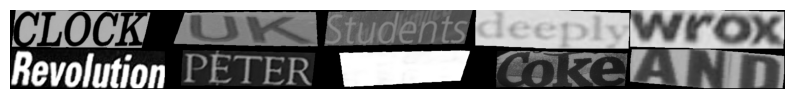

In [15]:
images, labels, label_lens = next(iter(train_loader))

def show_batch(images, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(images, nrow=5, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    print(labels)
    plt.show()

show_batch(images, labels)

In [16]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layer=3):
        super(CRNN, self).__init__()
        
        backbone = timm.create_model('resnet101', in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        for param in self.backbone[-unfreeze_layer:].parameters():
            param.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(
            512,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2))

    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)
        return x


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 512
n_layers = 2
dropout = 0.2
unfreeze_layer = 3

model = CRNN(vocab_size=vocab_size, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout, unfreeze_layer=unfreeze_layer).to(device)

In [18]:
model.eval()

test = torch.randn((64, 1, 32, 420)).to(device)
with torch.no_grad():
    output = model(test)

print(output.shape)

torch.Size([14, 64, 36])


In [19]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, labels, label_len in val_loader:
            inputs, labels, label_len = inputs.to(device), labels.to(device), label_len.to(device)

            outputs = model(inputs)  # outputs shape: (seq_length, batch_size, vocab_size)
            
            # Calculate logit_lens based on the output shape
            logit_lens = torch.full(
                size=(outputs.size(1),), # Use outputs.size(1) to get batch size
                fill_value=outputs.size(0), 
                dtype=torch.long
            ).to(device)
            
            loss = criterion(outputs, labels, logit_lens, label_len)
            losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    return avg_loss

In [20]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Initialize with infinity
    best_model_path = 'best_model_crnn.pth'  # Path to save the best model

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []

        for idx, (inputs, labels, label_len) in enumerate(train_loader):
            inputs, labels, label_len = inputs.to(device), labels.to(device), label_len.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)  
            # Ensure logit_lens (input_lengths) has size (batch_size,) 
            logit_lens = torch.full(
                size=(outputs.size(1),), # Change inputs.size(1) to outputs.size(1) 
                fill_value=outputs.size(0), 
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logit_lens, label_len)
            loss.backward()
            clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss {val_loss:.4f}')

        # Check if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        scheduler.step()

    return train_losses, val_losses


In [29]:
epochs = 100
lr = 0.001
weight_decay = 1e-5
scheduler_step_size = epochs * 0.4

criterion = nn.CTCLoss(blank= char_to_idx["-"], zero_infinity= True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)

In [30]:
train_loss, val_loss = fit(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device)

KeyboardInterrupt: 

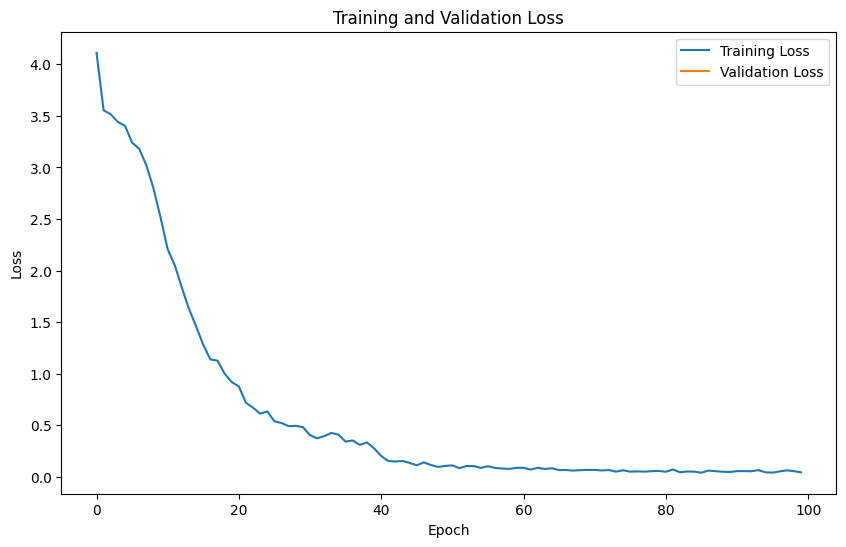

In [31]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_losses(train_loss, val_loss)


In [32]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Val loss:", val_loss)
print("Test loss:", test_loss)

Val loss: 1.139797528584798
Test loss: 1.2857208805424827


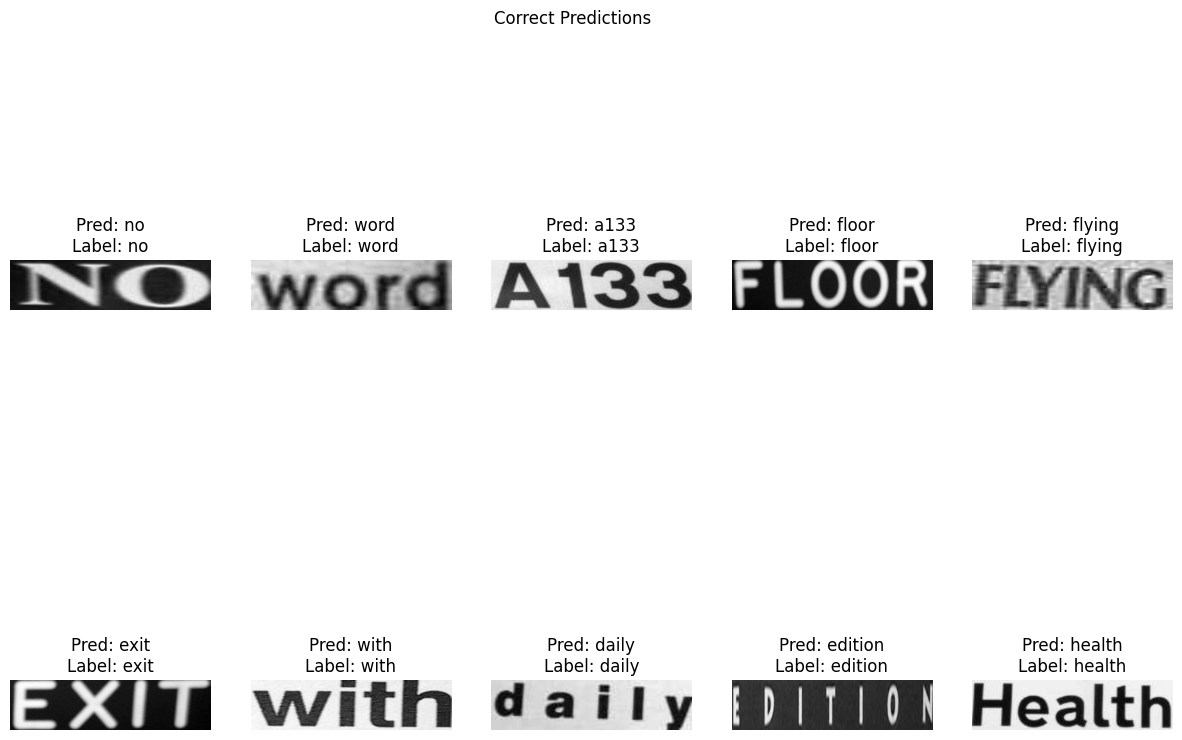

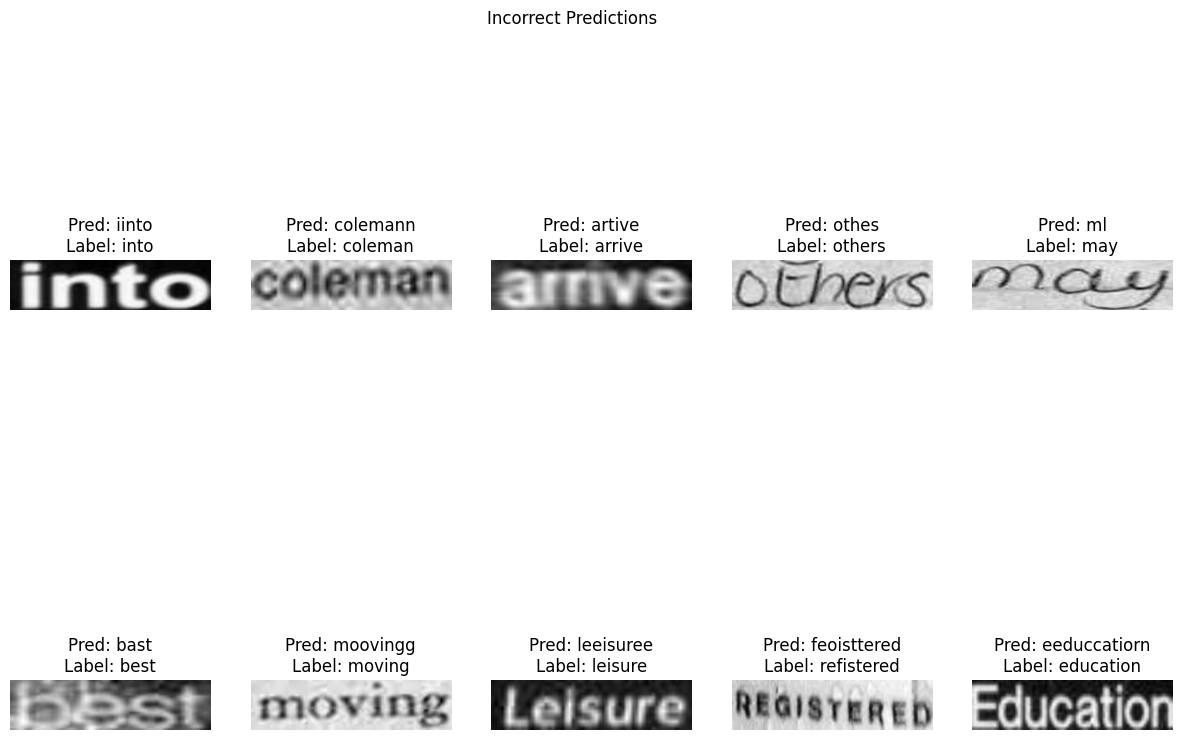

In [51]:
def show_correct_and_incorrect_predictions(model, data_loader, idx_to_char, device, max_images=10):
    model.eval() 
    correct_images = []
    correct_preds = []
    correct_labels = []
    
    incorrect_images = []
    incorrect_preds = []
    incorrect_labels = []

    with torch.no_grad():
        for inputs, labels, label_lens in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            decoded_outputs = decode(outputs.permute(1, 0, 2).argmax(dim=2), idx_to_char)
            decoded_labels = ["".join([idx_to_char[i.item()] for i in label[:length]]) for label, length in zip(labels, label_lens)]
            
            for i in range(len(inputs)):
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  
                
                if decoded_outputs[i] == decoded_labels[i]:
                    correct_images.append(img)
                    correct_preds.append(decoded_outputs[i])
                    correct_labels.append(decoded_labels[i])
                else:
                    incorrect_images.append(img)
                    incorrect_preds.append(decoded_outputs[i])
                    incorrect_labels.append(decoded_labels[i])

                if len(correct_images) >= max_images and len(incorrect_images) >= max_images:
                    break

            if len(correct_images) >= max_images and len(incorrect_images) >= max_images:
                break

    def plot_images(images, preds, labels, title):
        plt.figure(figsize=(15, 10))
        for i in range(len(images)):
            plt.subplot(2, max_images // 2, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.title(f"Pred: {preds[i]}\nLabel: {labels[i]}")
            plt.axis('off')
        plt.suptitle(title)
        plt.show()

    if correct_images:
        plot_images(correct_images[:max_images], correct_preds[:max_images], correct_labels[:max_images], "Correct Predictions")
    
    if incorrect_images:
        plot_images(incorrect_images[:max_images], incorrect_preds[:max_images], incorrect_labels[:max_images], "Incorrect Predictions")

show_correct_and_incorrect_predictions(model, test_loader, idx_to_char, device, max_images=10)


In [38]:
model = CRNN(vocab_size=36, hidden_size=512, n_layers=2, dropout=0.2, unfreeze_layer=3).to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()



C:\Users\hieuh\AppData\Local\Temp\ipykernel_6200\4173643455.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


CRNN(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

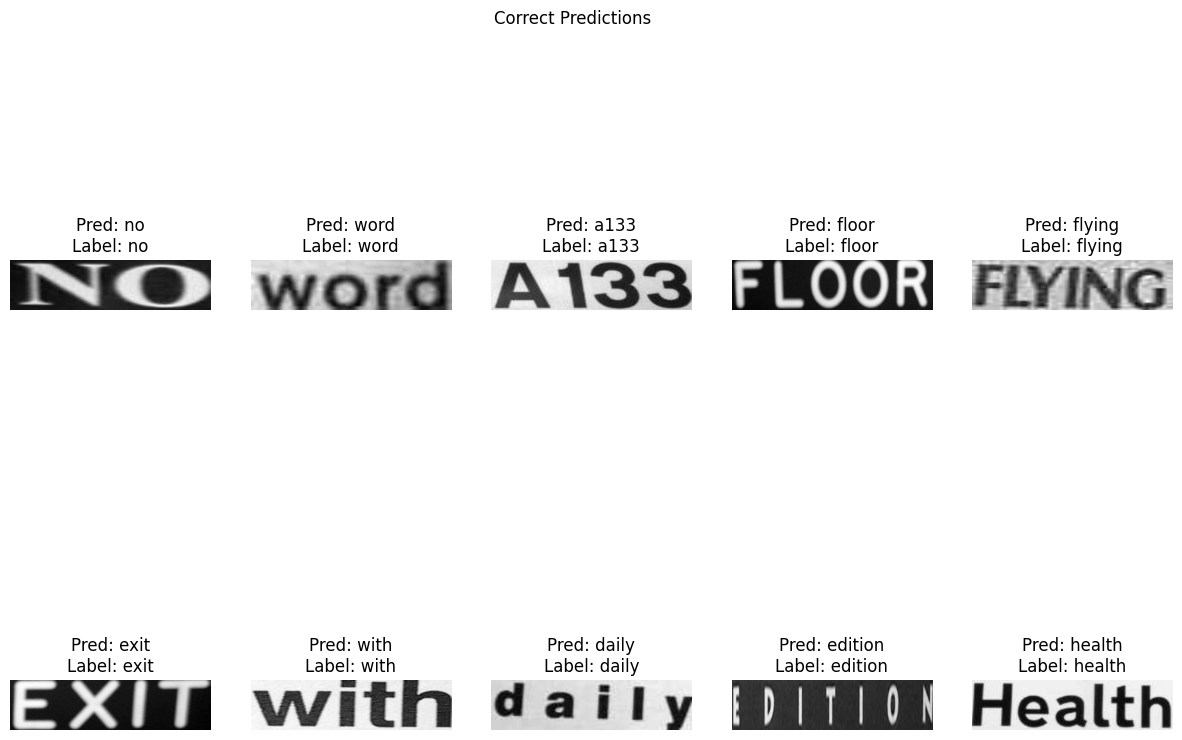

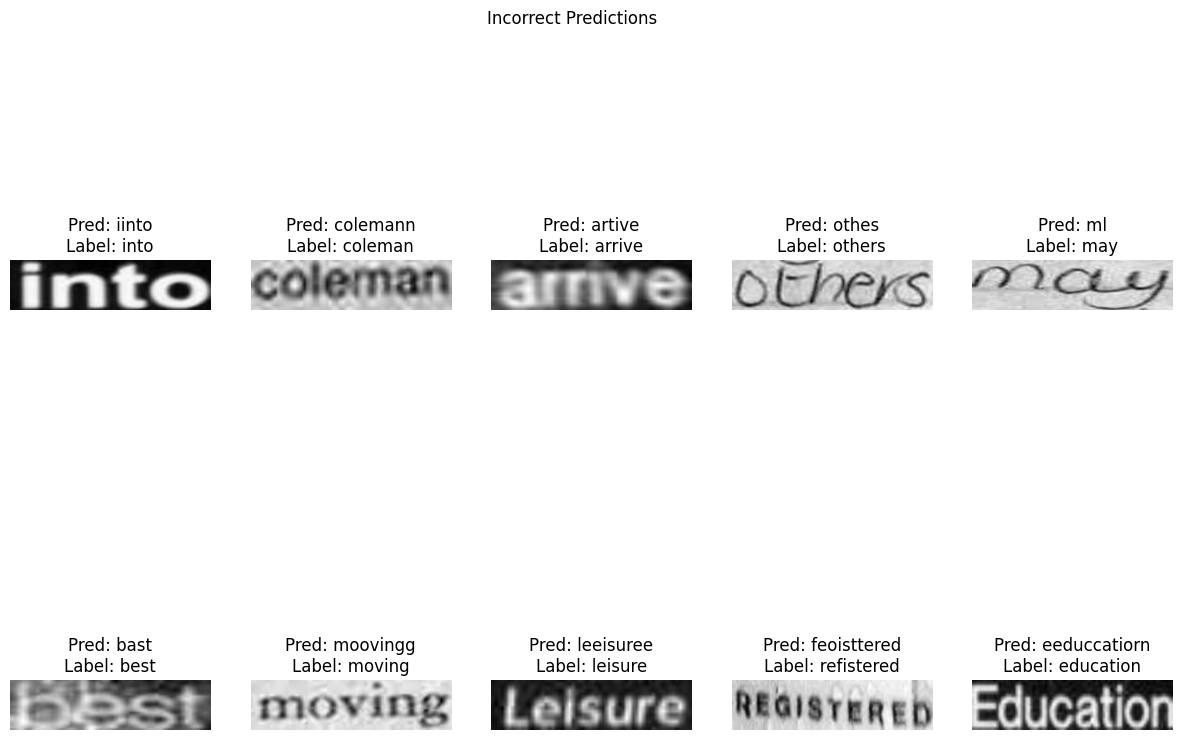

In [52]:
show_correct_and_incorrect_predictions(model, test_loader, idx_to_char, device, max_images=10)